![image](https://raw.githubusercontent.com/pfackeldey/evermore/main/assets/logo.png)

`evermore` is a library to write binned template models for statistical inference.
It focusses on the following aspects:
- Python API (model building feels like PyTorch)
- Performance: everything is JIT-compilable with `jax.jit`, vectorizable with `jax.vmap`, and scalable to multi-device systems using JAX's distributive features.
- Auto-differentiation: everything is differentiable with `jax.grad`
- Every component in `evermore` is a [PyTree](https://docs.jax.dev/en/latest/pytrees.html) $\rightarrow$ strong interopability with the JAX ecosystem (optimizer, debugging, visualizations, etc)

This notebook is a small demo of what you can do in `evermore`.

In [1]:
import typing as tp

import jax
import jax.numpy as jnp
from flax import nnx
from jaxtyping import Array, Float, PyTree

import evermore as evm

jax.config.update("jax_enable_x64", True) # we use 64 bit precision (JAX defaults to 32 bit)

In [2]:
# let's define some types we can use throughout this demo

# Float64 scalar
F64: tp.TypeAlias = Float[Array, ""]

# histograms / templates
Hist1D: tp.TypeAlias = Float[Array, "nbins"]
Hists1D: tp.TypeAlias = PyTree[Hist1D]

# Model Definition

Here, we implement a statistical model that is based on the four parameters defined in the above cell:
- `mu` scales unconstrained the signal histogram (our POI)
- `norm1` scales the first background (`bkg1`) by $\pm 10\%$
- `norm2` scales the second background (`bkg2`) by $\pm 5\%$
- `shape` scales the first and second background (correlated) by a reference shape Up and shape Down template using [CMS Combine's](https://cms-analysis.github.io/HiggsAnalysis-CombinedLimit/latest/) interpolation method.

In Combine the equivalent datacard would look as follows:
```text
imax 1  number of channels
jmax 2  number of backgrounds
kmax 3  number of nuisance parameters (sources of systematical uncertainties)
------------
bin           bin1
observation   37.0
------------
bin           bin1      bin1    bin1
process       signal    bkg1    bkg2
process       0         1       2
rate          3.0       10.0    20.0
------------
norm1  lnN    -         1.1     -
norm2  lnN    -         -       1.05
shape  shape  -         1.0     1.0
```
---
**Additional Info**:

Here we use for the shape yields (Up / Down):
- Up:
  - bkg1: `12.0`
  - bkg2: `23.0`
- Down:
  - bkg1: `8.0`
  - bkg2: `19.0`

# Model definition in evermore (e.g. using `flax.nnx.Module`)

In [3]:
# 'dataclass'/'torch.Module'-like model definition
class Model(nnx.Module):
  def __init__(self, mu: F64 = 0.0, norm1: F64 = 0.0, norm2: F64 = 0.0, shape: F64 = 0.0):
    self.mu = evm.Parameter(value=mu, name="mu")
    self.norm1 = evm.NormalParameter(value=norm1, name="norm1", tags={"theory"})
    self.norm2 = evm.NormalParameter(value=norm2, name="norm2", tags={"theory"})
    self.shape = evm.NormalParameter(value=shape, name="shape")

  def __call__(self, hists: Hists1D) -> Hists1D:
    # collect modified expectations
    expectations = {}

    # signal process
    sig_mod = self.mu.scale()
    expectations["signal"] = sig_mod(hists["nominal"]["signal"])

    # bkg1 process
    bkg1_lnN = self.norm1.scale_log(up=jnp.array([1.1]), down=jnp.array([0.9])) # +/- 10%
    bkg1_shape = self.shape.morphing(
      up_template=hists["shape_up"]["bkg1"],
      down_template=hists["shape_down"]["bkg1"],
    )
    # combine modifiers for a combined application
    bkg1_mod = evm.modifier.Compose(bkg1_lnN, bkg1_shape)
    expectations["bkg1"] = bkg1_mod(hists["nominal"]["bkg1"])

    # bkg2 process
    bkg2_lnN = self.norm2.scale_log(up=jnp.array([1.05]), down=jnp.array([0.95])) # +/- 5%
    bkg2_shape = self.shape.morphing(
      up_template=hists["shape_up"]["bkg2"],
      down_template=hists["shape_down"]["bkg2"],
    )
    # combine modifiers for a combined application
    bkg2_mod = evm.modifier.Compose(bkg2_lnN, bkg2_shape)
    expectations["bkg2"] = bkg2_mod(hists["nominal"]["bkg2"])

    # return the modified expectations
    return expectations



model = Model()

# let's have a look at them
nnx.display(model)

In [4]:
# histograms / templates (just an example how they can be structured)
hists = {
  "nominal": {
    "signal": jnp.array([3.0]),
    "bkg1": jnp.array([10.0]),
    "bkg2": jnp.array([20.0]),
  },
  "shape_up": {
    "bkg1": jnp.array([12.0]),
    "bkg2": jnp.array([23.0]),
  },
  "shape_down": {
    "bkg1": jnp.array([8.0]),
    "bkg2": jnp.array([19.0]),
  },
}

# data
observation = jnp.array([37.0])

In [5]:
from functools import partial

# Evaluate the model
# evm.util.sum_over_leaves: sums over all leaves in a pytree (here: the different modified process expectations)
expectation = evm.util.sum_over_leaves(nnx.jit(model)(hists))
print("Expectation:", expectation)

# Evaluate many models at once (by vmapping over a batch of mus)
@partial(nnx.vmap, in_axes=(0, None))
@nnx.jit
def batched_expectation(mu: F64, hists: Hists1D) -> Hists1D:
  return evm.util.sum_over_leaves(Model(mu=mu)(hists))

mus = jnp.r_[0:1:11j] # testing 'mu' values from 0 to 1 in 0.1 steps
expectations = batched_expectation(mus, hists)
print("Batched Expectation:", expectations)


Expectation: [30.]
Batched Expectation: [[30. ]
 [30.3]
 [30.6]
 [30.9]
 [31.2]
 [31.5]
 [31.8]
 [32.1]
 [32.4]
 [32.7]
 [33. ]]


# Negative log-likelihood (`loss` function)

The likelihood function of a binned template model is defined as follows:

$\mathcal{L}(d|\phi) = \prod_{i}^{n} \frac{\lambda_i(\phi)^{d_i}}{d_i!} e^{-\lambda_i(\phi)} \cdot \prod_j^p \pi_j\left(\phi_j\right)
$,

The first product is a Poisson per bin, and the second product is the constraint from each constraint pdf.

With:
- $\phi$ is the set of parameters (here: `mu`, `norm1`, `norm2`, `shape`)
- $\lambda_i(\phi)$ is the model prediction for bin $i$ (here: `model`)
- $d_i$ is the observed data in bin $i$ (here: `observation`)
- $\pi_j\left(\phi_j\right)$ is the constraint probability density function (pdf) for parameter $j$.


### Our `loss` function:

The negative log-likelihood of the above likelihood:

$\mathcal{-2 \ln L}(d|\phi) = -\sum_{i}^{n} \frac{\lambda_i(\phi)^{d_i}}{d_i!} e^{-\lambda_i(\phi)} - \sum_j^p \pi_j\left(\phi_j\right)
$

In [6]:
# negative log-likelihood implementation
Args: tp.TypeAlias = tuple[
  nnx.GraphDef, # graphdef from `nnx.split`
  nnx.State,    # static state from `nnx.split`
  Hists1D,      # initial expectations for the histograms / templates
  Hist1D,       # observation: 𝑑
]

@nnx.jit
def loss(dynamic: nnx.State, args: Args) -> F64:
  # unpack args
  graphdef, static, hists, observation = args

  # recombine model: 𝜙
  model = nnx.merge(graphdef, dynamic, static)

  # calculate model expectations: 𝜆(𝜙)
  expectations = model(hists)

  # first term: Poisson PDF
  loss_val = (
    evm.pdf.PoissonContinuous(evm.util.sum_over_leaves(expectations))
    .log_prob(observation)
    .sum()
  )

  # second term: add constraint per parameter 𝜋(𝜙)
  constraints = evm.loss.get_log_probs(model)
  loss_val += evm.util.sum_over_leaves(constraints)

  # return -2 * sum
  return -2.0 * jnp.sum(loss_val)

### Great, now it's time for a minimization to estimate the bestfit values of our parameters

In [7]:
import optimistix as optx  # a JAX-friendly optimizer library with 2nd order solvers

In [8]:
# minimize `loss` with 1000 steps using the BFGS minimizer
solver = optx.BFGS(rtol=1e-5, atol=1e-7)

# split the set of params into `dynamic` and `static` parts:
# `dynamic`: the ones that should be optimized by the minimizer
# `static` : the ones that are static (i.e. frozen), or other arrays / metadata
graphdef, dynamic, static = nnx.split(model, evm.filter.is_dynamic_parameter, ...)

# run the minimization
fitresult = optx.minimise(
  loss,
  solver,
  dynamic,
  args=(graphdef, static, hists, observation),
  max_steps=1_000,
)

bestfit_model = nnx.merge(graphdef, fitresult.value, static)
nnx.display(bestfit_model)

### Evermore's filter system

A filter is used by `nnx.split` to decide wether a parameter belongs in the `dynamic` (to be optimized) or `static` ('frozen') part.

`evermore` provides some useful filters out-of-the box:
- `evm.filter.is_parameter`: all parameters
- `evm.filter.is_not_frozen`: any object that has `.frozen=False`
- `evm.filter.is_dynamic_parameter`: all _parameters_ which have `frozen=False` (what you usually want to use)
- `evm.filter.HasName`: can filter by `.name` of parameters
- `evm.filter.HasTags`: can filter by arbitrary `.tags` set on parameters

Filters can also be combined by using `nnx's` filter DSL, e.g.: 

```python
# select parameters that aren't frozen _and_ have the 'theory' tag set 
my_filter = nnx.All(evm.filter.is_not_frozen, evm.filter.HasTags({"theory"}))
```

See the following example:

In [9]:
# minimize `loss` with 1000 steps using the BFGS minimizer
solver = optx.BFGS(rtol=1e-5, atol=1e-7)

# split the set of params into `dynamic` and `static` parts, selecting only non-frozen parameters with the "theory" tag:
theory_not_frozen = nnx.All(evm.filter.is_dynamic_parameter, evm.filter.HasTags({"theory"}))
graphdef, dynamic, static = nnx.split(model, theory_not_frozen, ...)

# run the minimization
fitresult_ = optx.minimise(
  loss,
  solver,
  dynamic,
  args=(graphdef, static, hists, observation),
  max_steps=1_000,
)

bestfit_model_ = nnx.merge(graphdef, fitresult_.value, static)
nnx.display(bestfit_model_)

### Likelihood Profile over `mu`

In [10]:
@nnx.jit
def fixed_mu_fit(mu: F64) -> F64:
  # create a new model setting `mu` to the desired value
  model = Model(mu=mu)

  # split again, the 'frozen=True' puts `mu` into the `static` part now
  model.mu.set_metadata(frozen=True)
  graphdef, dynamic, static = nnx.split(model, evm.filter.is_dynamic_parameter, ...)

  # split again, the 'frozen=True' puts `mu` into the `static` part now
  # could've also used a filter instead:
  # freeze_mu_filter = nnx.All(evm.filter.is_dynamic_parameter, nnx.Not(evm.filter.HasName("mu")))
  # graphdef, dynamic, static = nnx.split(model, freeze_mu_filter, ...)

  # reassemble args
  args: Args = (graphdef, static, hists, observation)

  fitresult = optx.minimise(
    loss,
    solver,
    dynamic,
    args=args,
    max_steps=1_000,
  )

  # return -2 * nll at the bestfit values
  return loss(fitresult.value, args)

In [11]:
# run likelihood profile over mu=0..5 (stepsize=0.25)
mus = jnp.linspace(0, 5, 21)
profile = []
for mu in mus:
  nll_value = fixed_mu_fit(mu)
  profile.append(nll_value)
  print(f"[for-loop] mu={mu:.2f}, NLL={nll_value:.6f}")

[for-loop] mu=0.00, NLL=0.809539
[for-loop] mu=0.25, NLL=0.649200
[for-loop] mu=0.50, NLL=0.506700
[for-loop] mu=0.75, NLL=0.381562
[for-loop] mu=1.00, NLL=0.273563
[for-loop] mu=1.25, NLL=0.182756
[for-loop] mu=1.50, NLL=0.109478
[for-loop] mu=1.75, NLL=0.054299
[for-loop] mu=2.00, NLL=0.017935
[for-loop] mu=2.25, NLL=0.001133
[for-loop] mu=2.50, NLL=0.004571
[for-loop] mu=2.75, NLL=0.028787
[for-loop] mu=3.00, NLL=0.074139
[for-loop] mu=3.25, NLL=0.140810
[for-loop] mu=3.50, NLL=0.228826
[for-loop] mu=3.75, NLL=0.338079
[for-loop] mu=4.00, NLL=0.468360
[for-loop] mu=4.25, NLL=0.619379
[for-loop] mu=4.50, NLL=0.790786
[for-loop] mu=4.75, NLL=0.982193
[for-loop] mu=5.00, NLL=1.193178


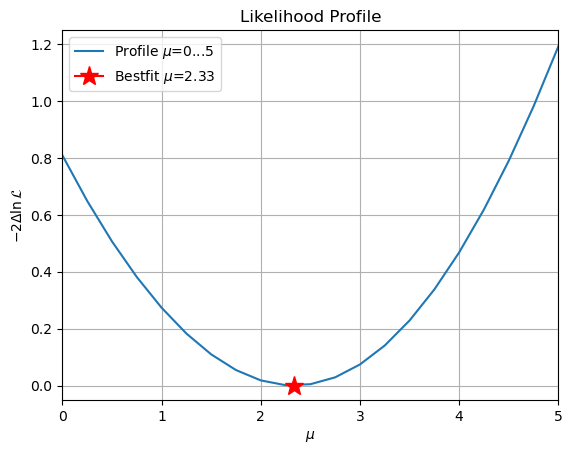

In [12]:
import matplotlib.pyplot as plt

ax = plt.subplot()

# profile
plt.plot(mus, profile, label=rf"Profile $\mu$=0...5")
# bestfit point
plt.plot(
  bestfit_model.mu.value,
  fitresult.state.f_info.f,
  marker="*",
  color="r",
  markersize=14,
  label=rf"Bestfit $\mu$={bestfit_model.mu.value:.2f}",
)

# styling
plt.title("Likelihood Profile")
plt.xlabel(r"$\mu$")
plt.ylabel(r"$-2\Delta \ln \mathcal{L}$")
plt.grid()
plt.legend()
plt.ylim(-0.05, 1.25)
plt.xlim(mus[0], mus[-1])

# show
plt.show()

### Leveraging JAX transformations...

In [13]:
# remember: `evermore` is fully compatible and transparent w.r.t JAX's transformations!
# -> we can `vmap` the profile and run all these fits in parallel!
vectorized_fixed_mu_fit = nnx.vmap(fixed_mu_fit)
profile_vec = vectorized_fixed_mu_fit(mus)

# make sure we got the same results
assert jnp.allclose(profile_vec, jnp.array(profile))

for mu, nll in zip(mus, profile_vec, strict=True):
  print(f"[jax.vmap] mu={mu:.2f}, NLL={nll:.6f}")

[jax.vmap] mu=0.00, NLL=0.809539
[jax.vmap] mu=0.25, NLL=0.649200
[jax.vmap] mu=0.50, NLL=0.506700
[jax.vmap] mu=0.75, NLL=0.381562
[jax.vmap] mu=1.00, NLL=0.273563
[jax.vmap] mu=1.25, NLL=0.182756
[jax.vmap] mu=1.50, NLL=0.109478
[jax.vmap] mu=1.75, NLL=0.054299
[jax.vmap] mu=2.00, NLL=0.017935
[jax.vmap] mu=2.25, NLL=0.001133
[jax.vmap] mu=2.50, NLL=0.004571
[jax.vmap] mu=2.75, NLL=0.028787
[jax.vmap] mu=3.00, NLL=0.074139
[jax.vmap] mu=3.25, NLL=0.140810
[jax.vmap] mu=3.50, NLL=0.228826
[jax.vmap] mu=3.75, NLL=0.338079
[jax.vmap] mu=4.00, NLL=0.468360
[jax.vmap] mu=4.25, NLL=0.619379
[jax.vmap] mu=4.50, NLL=0.790786
[jax.vmap] mu=4.75, NLL=0.982193
[jax.vmap] mu=5.00, NLL=1.193178


In [14]:
# compare performance (`jax.block_until_ready` to avoid async dispatch messing with `timeit`)
def forloop():
  out = []
  for mu in mus:
    out = jax.block_until_ready(fixed_mu_fit(mu))
  return jnp.array(out)

def vmap():
  return jax.block_until_ready(vectorized_fixed_mu_fit(mus))

In [15]:
%timeit forloop()

889 μs ± 2.99 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [16]:
%timeit vmap()

522 μs ± 4.34 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### Talking about JAX transformations... ✨***Gradients***✨

In [17]:
# evermore is fully differentiable:
graphdef, dynamic, static = nnx.split(model, evm.filter.is_dynamic_parameter, ...)
args = (graphdef, static, hists, observation)

grads = nnx.grad(loss)(dynamic, args)
nnx.display(nnx.pure(grads))

In [18]:
# also the gradient of a full minimization
grad_fixed_mu_fit = nnx.grad(fixed_mu_fit)
grad_fixed_mu_fit(mu=0.5)

Array(-0.53503495, dtype=float64, weak_type=True)

In [19]:
# also the gradients of a full profile
vectorized_grad_fixed_mu_fit = nnx.vmap(grad_fixed_mu_fit)
profile_grads = vectorized_grad_fixed_mu_fit(mus)

nnx.display(profile_grads)

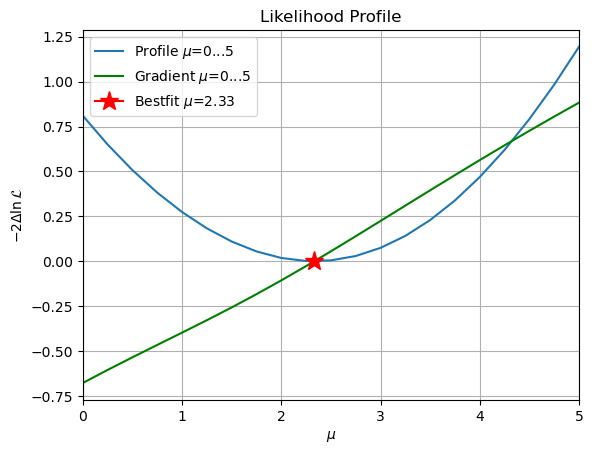

In [20]:
ax = plt.subplot()

# profile & gradients
plt.plot(mus, profile, label=rf"Profile $\mu$=0...5")
plt.plot(mus, profile_grads, color='green', label=rf"Gradient $\mu$=0...5")

# bestfit point
plt.plot(
  bestfit_model.mu.value,
  fitresult.state.f_info.f,
  marker="*",
  color="r",
  markersize=14,
  label=rf"Bestfit $\mu$={bestfit_model.mu.value:.2f}",
)

# styling
plt.title("Likelihood Profile")
plt.xlabel(r"$\mu$")
plt.ylabel(r"$-2\Delta \ln \mathcal{L}$")
plt.grid()
plt.legend()
plt.xlim(mus[0], mus[-1])

# show
plt.show()

# Bonus: use DNNs in your model!

In [21]:
# define model and mlp
class MLP(nnx.Module):
  def __init__(self, din: int, dmid: int, dout: int, *, rngs: nnx.Rngs):
    self.linear1 = nnx.Linear(din, dmid, rngs=rngs)
    self.linear2 = nnx.Linear(dmid, dout, rngs=rngs)

  def __call__(self, x: jax.Array):
    x = nnx.elu(self.linear1(x))
    return self.linear2(x)


class ModelWithMLP(nnx.Module):
  def __init__(self, mu: F64 = 0.0):
    # Stat model:
    self.model = Model(mu=mu)
    # MLP:
    # 3 inputs -> 10 hidden features -> 1 output
    self.mlp = MLP(3, 10, 1, rngs=nnx.Rngs(1234))

  def __call__(self, hists: Hists1D) -> Hists1D:
    # we use the MLP to modify the bin contents of the nominal bkg1 template
    modified_hists = {**hists} # shallow copy

    # dummy input to MLP (could be anything, here a simple 1,2,3 feature vector)
    modified_hists["nominal"]["bkg1"] += self.mlp(jnp.array([1.0, 2.0, 3.0]))

    # call original model with modified hists by MLP
    return self.model(modified_hists)

We can re-use the _exact_ same code as before, because `ModelWithMLP` is just another `PyTree`/`nnx.Module` that behaves in the exact same way as `Model`. 
It just holds additionally the `MLP` with it's own parameters, but `evermore's` filter system makes sure we can granularly define which parameters we want to optimize.

In [22]:
# minimize `loss` with 1000 steps using the BFGS minimizer
solver = optx.BFGS(rtol=1e-5, atol=1e-7)

model = ModelWithMLP()

# filter only dynamic evermore parameters, no MLP parameters(!)
graphdef, dynamic, static = nnx.split(model, evm.filter.is_dynamic_parameter, ...)
args = (graphdef, static, hists, observation)

# run the minimization
fitresult = optx.minimise(
  loss,
  solver,
  dynamic,
  args=args,
  max_steps=1_000,
)

# combine states back to nnx graph
bestfit_model_with_mlp = nnx.merge(graphdef, fitresult.value, static)

nnx.display(bestfit_model_with_mlp)

You can do anything with the MLP model as you could do before (e.g. likelihood profile)...

In [23]:
@nnx.jit
def fixed_mu_fit(mu: F64) -> F64:
  # create a new model setting `mu` to the desired value, now with MLP
  model = ModelWithMLP(mu=mu)

  # split again, this time using filter combination to freeze `mu`
  freeze_mu_filter = nnx.All(evm.filter.is_dynamic_parameter, nnx.Not(evm.filter.HasName("mu")))
  graphdef, dynamic, static = nnx.split(model, freeze_mu_filter, ...)

  # reassemble args
  args: Args = (graphdef, static, hists, observation)

  fitresult = optx.minimise(
    loss,
    solver,
    dynamic,
    args=args,
    max_steps=1_000,
  )

  # return -2 * nll at the bestfit values
  return loss(fitresult.value, args)

# likelihood profile over mu=0..5 (stepsize=0.25) with MLP, vectorized with `vmap`
mus = jnp.linspace(0, 5, 21)
profile = nnx.vmap(fixed_mu_fit)(mus)
profile_grads = nnx.vmap(nnx.grad(fixed_mu_fit))(mus)

nnx.display({"Profile": profile, "Profile Gradients": profile_grads})

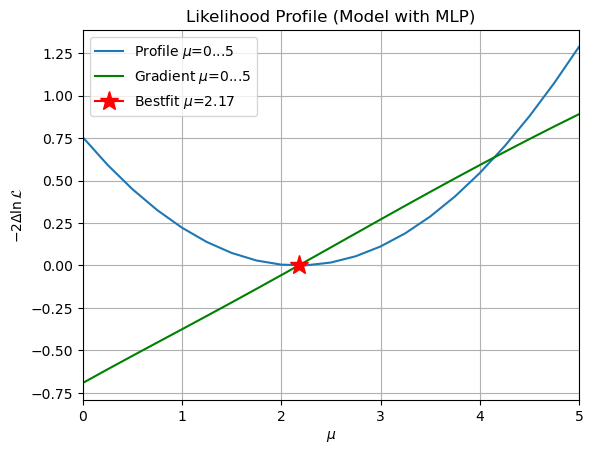

In [24]:
ax = plt.subplot()

# profile & gradients
plt.plot(mus, profile, label=rf"Profile $\mu$=0...5")
plt.plot(mus, profile_grads, color='green', label=rf"Gradient $\mu$=0...5")

# bestfit point
plt.plot(
  bestfit_model_with_mlp.model.mu.value,
  fitresult.state.f_info.f,
  marker="*",
  color="r",
  markersize=14,
  label=rf"Bestfit $\mu$={bestfit_model_with_mlp.model.mu.value:.2f}",
)

# styling
plt.title("Likelihood Profile (Model with MLP)")
plt.xlabel(r"$\mu$")
plt.ylabel(r"$-2\Delta \ln \mathcal{L}$")
plt.grid()
plt.legend()
plt.xlim(mus[0], mus[-1])

# show
plt.show()

Want to know the gradient of the MLP parameters w.r.t the negative log-likelihood?
Here you go:

In [25]:
model = ModelWithMLP()

# split model, this time MLP parameters are in `dynamic`, evermore parameters in `static`
is_not_evm_parameter = nnx.Not(evm.filter.is_parameter)
graphdef, dynamic, static = nnx.split(model, is_not_evm_parameter, ...)

# calculate gradients w.r.t MLP parameters
gradients = nnx.grad(loss)(dynamic=dynamic, args=(graphdef, static, hists, observation))
nnx.display(gradients)

# Bonus 2: pure JAX-based MIGRAD implementation in optimistix
(since ~1 month in `optimistix==0.0.11`)

In [26]:
import optimistix as optx

# use pure stat. model from above
model = Model()

graphdef, dynamic, static = nnx.split(model, evm.filter.is_dynamic_parameter, ...)

# MIGRAD is called 'DFP' in optimistix as it uses the
# Davidon–Fletcher–Powell formula (https://en.wikipedia.org/wiki/Davidon–Fletcher–Powell_formula)
# to iteratively update the hessian
migrad = optx.DFP(rtol=1e-5, atol=1e-7)

# run the minimization
fitresult = optx.minimise(
  loss,
  migrad,
  dynamic,
  args=(graphdef, static, hists, observation),
  max_steps=1_000,
)

bestfit_params_migrad = nnx.merge(graphdef, fitresult.value, static)
nnx.display(bestfit_params_migrad)

`optimistix` allows to construct powerful custom solvers, we can e.g. use MIGRAD for the hessian update and use trust-region for the step direction: 

In [27]:
import typing as tp

class MIGRADTrustRegion(optx.AbstractDFP):
  rtol: float
  atol: float
  norm: tp.Callable = optx.max_norm
  use_inverse: bool = False
  search: optx.AbstractSearch = optx.ClassicalTrustRegion() # <- use trust-region instead of line-search
  descent: optx.AbstractDescent = optx.NewtonDescent()
  verbose: frozenset[str] = frozenset()


migrad_with_trust_region = MIGRADTrustRegion(rtol=1e-5, atol=1e-7)

# run the minimization
fitresult = optx.minimise(
  loss,
  migrad_with_trust_region,
  dynamic,
  args=(graphdef, static, hists, observation),
  max_steps=1_000,
)

bestfit_params_migrad_with_trust_region = nnx.merge(graphdef, fitresult.value, static)
# check results
nnx.display({
  "MIGRAD": nnx.pure(bestfit_params_migrad),
  "MIGRAD with trust-region": nnx.pure(bestfit_params_migrad_with_trust_region)
})

# Bonus 3: Powerful & custom modifiers

In [28]:
# You can write custom functions that manipulate a histogram and
# turn it into a evm.Modifier
from functools import partial

# 3-bin histogram
hist = jnp.array([10., 15., 20.])

# 3 parameter values (decorrelated per bin)
parameter = evm.NormalParameter(value=jnp.array([1.1, 0.8, 1.03]))

def custom(parameter: evm.Parameter, hist: Hist1D) -> Hist1D:
  return hist + parameter.value * jnp.array([1.0, 1.5, 2.0])

# use `evm.effect.Lambda` for custom functions
custom_modifier = evm.Modifier(
  parameter=parameter,
  effect=evm.effect.Lambda(custom, normalize_by="offset")
)

# modify a hist
print("Hist scaled by custom_modifier:", custom_modifier(hist))

nnx.display({"Custom modifier": custom_modifier})

Hist scaled by custom_modifier: [11.1  16.2  22.06]


Create powerful modifiers using evermore's modifier manipulations:
- `evm.modifier.BooleanMask`: mask the application of a modifier
- `evm.modifier.Where`: conditionally apply modifiers to bins
- `evm.modifier.Transform{Offset,Scale,}`: apply custom transformations to the scaling factors of a modifier at application time

They can be arbitrarly nested and combined.

See the following example:

In [29]:
# combine the custom modifier with other modifiers
# this is norm-sys in pyhf, or lnN in combine
lnN = parameter.scale_log(up=1.15, down=0.79)

combined_modifier = evm.modifier.Compose(custom_modifier, lnN)
print("Custom modifier + lnN:", combined_modifier(hist))

# apply only to bins with >10 events
mask = hist > 10.
masked_lnN = evm.modifier.BooleanMask(mask, lnN)

# clip the scaling factor of the custom modifier to be within [0.98, 1.15]
clipped_custom_modifier = evm.modifier.Transform(
  transform_fn=partial(jnp.clip, min=0.98, max=1.15),
  modifier=custom_modifier,
)

# combine everything
fancy_modifier = evm.modifier.Compose(clipped_custom_modifier, masked_lnN)
print("Fancy modifier (clipped custom + masked lnN):", fancy_modifier(hist))

nnx.display({"Fancy modifier (clipped custom + masked lnN)": fancy_modifier})

Custom modifier + lnN: [12.94465867 18.11645781 25.47559193]
Fancy modifier (clipped custom + masked lnN): [11.1        18.06054281 24.42469489]


# Bonus 4: Toy Sampling (vectorized)

## Prefit

In [30]:
@nnx.jit
def prefit_toy_expectation(rngs: nnx.Rngs, model: Model) -> Hist1D:
  sampled_model = evm.sample.sample_from_priors(rngs, model)
  expectations = sampled_model(hists)
  return evm.util.sum_over_leaves(expectations)

In [31]:
# generate a single toy prefit dataset based on the parameter priors
rngs = nnx.Rngs(0)
model = Model()

asimov = evm.util.sum_over_leaves(model(hists))

# Single sample
sample = prefit_toy_expectation(rngs, model)
nnx.display({"asimov sample": asimov,"toy sample": sample})

In [32]:
# generate multiple samples
rngs = nnx.Rngs(0)
model = Model()

# sample 1000 toy prefit datasets
@nnx.split_rngs(splits=1_000)
@partial(nnx.vmap, in_axes=(0, None))
def vec_prefit_toy_expectation(rngs, model):
  return prefit_toy_expectation(rngs, model)

nnx.display(vec_prefit_toy_expectation(rngs, model))

## Postfit

In [33]:
# define postfit toy expectation function
@partial(nnx.jit, static_argnames=("n_samples",))
def postfit_toy_expectation(
  rngs: nnx.Rngs,
  dynamic: nnx.State,
  *,
  args: Args,
  mask: PyTree[bool] | None = None,
  n_samples: int = 1,
) -> Hist1D:
  # cov matrix
  loss_fn = jax.tree_util.Partial(loss, args=args)
  covariance_matrix = evm.loss.covariance_matrix(loss_fn, dynamic)

  # sample from covariance matrix
  toy_dynamic = evm.sample.sample_from_covariance_matrix(
    rngs=rngs,
    params=dynamic,
    covariance_matrix=covariance_matrix,
    mask=mask,
    n_samples=n_samples,
  )

  # unpack args, recombine model
  graphdef, static, hists, _ = args
  toy_model = nnx.merge(graphdef, toy_dynamic, static)

  expectations = toy_model(hists)
  return evm.util.sum_over_leaves(expectations)

In [34]:
# generate a single postfit toy dataset
rngs = nnx.Rngs(0)
model = Model()
graphdef, dynamic, static = nnx.split(model, evm.filter.is_dynamic_parameter, ...)
args = (graphdef, static, hists, observation)

postfit_sample = postfit_toy_expectation(rngs, dynamic, args=args)
nnx.display(postfit_sample)

In [35]:
# generate multiple postfit toy datasets
rngs = nnx.Rngs(0)
model = Model()
graphdef, dynamic, static = nnx.split(model, evm.filter.is_dynamic_parameter, ...)
args = (graphdef, static, hists, observation)

# sample 1000 postfit toy datasets, evermore directly supports passing down `n_samples` in this case
# but we could also manually `vmap` as shown below
postfit_samples = postfit_toy_expectation(rngs, dynamic, args=args, n_samples=1_000)
nnx.display(postfit_samples)

# # or use nnx.split again
# # sample 1000 toy postfit datasets
# @nnx.split_rngs(splits=1_000)
# @partial(nnx.vmap, in_axes=(0, None))
# def vec_postfit_toy_expectation(rngs, dynamic):
#   return postfit_toy_expectation(rngs, dynamic, args=args)[0]

# nnx.display(vec_postfit_toy_expectation(rngs, dynamic))

# Bonus 5: Model Composability

Like PyTorch you can compose together multiple `nnx.Module`s. This allows to convienently structure more complex statistical models, or e.g. 'swap-out' different models for certain processes.

Let's have a look at an example using the same model as introduced in the beginning. Here we split into different models by physics process (instead we could also split by systematic modifer group):

In [36]:
# 'dataclass'/'torch.Module'-like model definition
class SignalModel(nnx.Module):
  def __init__(self, mu: F64):
    self.mu = evm.Parameter(value=mu, name="mu")

  def __call__(self, hist: Hist1D) -> Hist1D:
    # signal process
    sig_mod = self.mu.scale()
    return sig_mod(hist)


class BkgModel(nnx.Module):
  def __init__(self, norm_name: str, norm: F64, shape: evm.NormalParameter[F64]):
    self.norm = evm.NormalParameter(value=norm, name=norm_name, tags={"theory"})
    self.shape = shape

  def lnN(self):
    assert False, "Not implemented!"

  def __call__(self, hist: Hist1D, up: Hist1D, down: Hist1D) -> Hist1D:
    bkg_lnN = self.lnN()
    bkg_shape = self.shape.morphing(up_template=up, down_template=down)
    # combine modifiers for a combined application
    bkg_mod = evm.modifier.Compose(bkg_lnN, bkg_shape)
    return bkg_mod(hist)
  

class Bkg1Model(BkgModel):
  def lnN(self):
    return self.norm.scale_log(up=jnp.array([1.1]), down=jnp.array([0.9])) # +/- 10%


class Bkg2Model(BkgModel):
  def lnN(self):
    return self.norm.scale_log(up=jnp.array([1.05]), down=jnp.array([0.95])) # +/- 5%


class ComposedModel(nnx.Module):
  def __init__(self, mu: F64 = 0.0, norm1: F64 = 0.0, norm2: F64 = 0.0, shape: F64 = 0.0):
    # we initialize the shape parameter once to share the same parameter between bkg1 and bkg2 (correlation!)
    self.shape = evm.NormalParameter(value=shape, name="shape")

    # initialize sub-models
    self.signal_model = SignalModel(mu=mu)
    self.bkg1_model = Bkg1Model(norm_name="norm1", norm=norm1, shape=self.shape)
    self.bkg2_model = Bkg2Model(norm_name="norm2", norm=norm2, shape=self.shape)

  def __call__(self, hists: Hists1D) -> Hists1D:
    # collect modified expectations
    expectations = {}

    # signal process
    expectations["signal"] = self.signal_model(hists["nominal"]["signal"])

    # bkg1 process
    expectations["bkg1"] = self.bkg1_model(
      hists["nominal"]["bkg1"],
      hists["shape_up"]["bkg1"],
      hists["shape_down"]["bkg1"],
    )

    # bkg2 process
    expectations["bkg2"] = self.bkg2_model(
      hists["nominal"]["bkg2"],
      hists["shape_up"]["bkg2"],
      hists["shape_down"]["bkg2"],
    )

    # return the modified expectations
    return expectations

In [37]:
composed_model = ComposedModel()
nnx.display(composed_model)

In [38]:
# Same code as before to do the fit with the composed model!

# minimize `loss` with 1000 steps using the BFGS minimizer
solver = optx.BFGS(rtol=1e-5, atol=1e-7)

# split the set of params into `dynamic` and `static` parts:
# `dynamic`: the ones that should be optimized by the minimizer
# `static` : the ones that are static (i.e. frozen), or other arrays / metadata
graphdef, dynamic, static = nnx.split(composed_model, evm.filter.is_dynamic_parameter, ...)

# run the minimization
fitresult = optx.minimise(
  loss,
  solver,
  dynamic,
  args=(graphdef, static, hists, observation),
  max_steps=1_000,
)

bestfit_composed_model = nnx.merge(graphdef, fitresult.value, static)
nnx.display(bestfit_composed_model)

In [39]:
# make sure we got the same results as before (order is different because of different model structure)
nnx.display(nnx.pure(nnx.state(bestfit_composed_model).filter(evm.filter.is_dynamic_parameter)))
nnx.display(nnx.pure(nnx.state(bestfit_model).filter(evm.filter.is_dynamic_parameter)))

# Summary

`evermore` is heavily focussing on interopability with the JAX and ML ecosystem. That way you can use various features and tools out-of-the-box, such as:
- Powerful modifiers
- GPU & multi-GPU acceleration
- Vectorization of fits, sampling, ...
- Gradients, Hessian, ...
- Many optimizers, most notably: `optax` & `optimistix`
- Natural integration with evaluating neural networks
- Live inspection using `treescope`
- Fit checkpointing using `orbax`
- `weights and biases` / `mlflow` / `tensorboard`: to visualize and debug minimizations
- ...

Feel free to check it out:
- Github: https://github.com/pfackeldey/evermore
- docs: https://evermore.readthedocs.io/en/latest/index.html
